In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import solve_bvp


$$
\varepsilon y'' + (2x+1) y' + 2y = 0, \quad \varepsilon \ll 1, \quad y(0)=A, \quad y(1)=B
$$


In [2]:
eps = 0.01
A, B = 0, 1


In [3]:
# Метод прогонки
def solve_progonka(eps, A, B, N=1000):
    x = np.linspace(0, 1, N+1)
    dx = x[1] - x[0]
    
    alpha = np.zeros(N+1)
    beta = np.zeros(N+1)
    
    for i in range(1, N+1):
        xi = x[i]
        a2, a1, a0 = eps, 2*xi + 1, 2
        
        A_coef = a2 / dx**2 + a1 / (2 * dx)
        B_coef = -2 * a2 / dx**2 + a0
        C_coef = a2 / dx**2 - a1 / (2 * dx)
        
        alpha[i] = -A_coef / (B_coef + C_coef * alpha[i-1])
        beta[i] = (0 - C_coef * beta[i-1]) / (B_coef + C_coef * alpha[i-1])
    
    y = np.zeros(N+1)
    y[N] = B
    for i in range(N-1, -1, -1):
        y[i] = alpha[i] * y[i+1] + beta[i]
    
    return x, y


In [4]:
# SciPy решение
def solve_scipy(eps, A, B):
    def ode_system(x, y):
        y1, y2 = y
        return np.vstack((
            y2,
            -((2*x + 1)*y2 + 2*y1) / eps
        ))

    def boundary_conditions(ya, yb):
        return np.array([ya[0] - A, yb[0] - B])

    x_vals = np.linspace(0, 1, 1000)
    y_guess = np.zeros((2, x_vals.size))
    
    solution = solve_bvp(ode_system, boundary_conditions, x_vals, y_guess)
    return solution.x, solution.y[0]


In [ ]:
# Аналитическое решение методом сращивания
# Для уравнения εy'' + (2x+1)y' + 2y = 0, y(0)=A, y(1)=B
# Внешнее разложение: (2x+1)y' + 2y = 0 → y = C/(2x+1)
# Граничное условие y(1)=B: B = C/3 → C = 3B
# Но y(0) = 3B ≠ A, нужен пограничный слой у x=0

def y_analytical(x, eps, A, B):
    # Составное разложение с учетом пограничного слоя
    # y_outer = 3B/(2x+1) - внешнее решение
    # y_inner = (A - 3B)*exp(-x/√ε) - пограничный слой
    # Упрощенная формула учитывающая оба эффекта:
    y_outer = 3*B / (2*x + 1)
    boundary_layer = (A - 3*B) * np.exp(-x / np.sqrt(eps))
    return y_outer + boundary_layer

print(f"Аналитические решения для ε = {eps}, A = {A}, B = {B}:")
print(f"y(0) = {y_analytical(0, eps, A, B):.6f} (ожидается {A})")
print(f"y(1) = {y_analytical(1, eps, A, B):.6f} (ожидается {B})")


Аналитические решения для ε = 0.01, A = 0, B = 1:
y(0) = 1.000000 (ожидается 0)
y(1) = 0.334074 (ожидается 1)


In [6]:
# Численные решения
x_prog, y_prog = solve_progonka(eps, A, B)
x_scipy, y_scipy = solve_scipy(eps, A, B)

print(f"Численные решения для ε = {eps}, A = {A}, B = {B}:")
print(f"Прогонка: y(0) = {y_prog[0]:.6f}, y(1) = {y_prog[-1]:.6f}")
print(f"SciPy: y(0) = {y_scipy[0]:.6f}, y(1) = {y_scipy[-1]:.6f}")


Численные решения для ε = 0.01, A = 0, B = 1:
Прогонка: y(0) = 0.000000, y(1) = 1.000000
SciPy: y(0) = 0.000000, y(1) = 1.000000


In [ ]:
# Сравнение решений с помощью DataFrame
x_compare = [0.001, 0.2, 0.5, 0.8, 1.0]  # Избегаем x=0 для численной устойчивости
data = []

for x_val in x_compare:
    y_anal = y_analytical(x_val, eps, A, B)
    y_prog_val = np.interp(x_val, x_prog, y_prog)
    y_sci_val = np.interp(x_val, x_scipy, y_scipy)
    
    data.append({
        'x': x_val,
        'Аналитический': y_anal,
        'Прогонка': y_prog_val,
        'SciPy': y_sci_val,
        'Ошибка_анал': abs(y_anal - y_sci_val),
        'Ошибка_прог': abs(y_prog_val - y_sci_val)
    })

df = pd.DataFrame(data)
print("Сравнение решений в различных точках:")
print(df.round(6))


Сравнение решений в различных точках:
     x  Аналитический  Прогонка     SciPy  Ошибка_анал  Ошибка_прог
0  0.0       1.000000  0.000000  0.000000     1.000000     0.000000
1  0.2       0.715743  2.160594  2.160596     1.444853     0.000003
2  0.5       0.501250  1.504250  1.504250     1.003000     0.000001
3  0.8       0.385526  1.154707  1.154707     0.769182     0.000000
4  1.0       0.334074  1.000000  1.000000     0.665926     0.000000


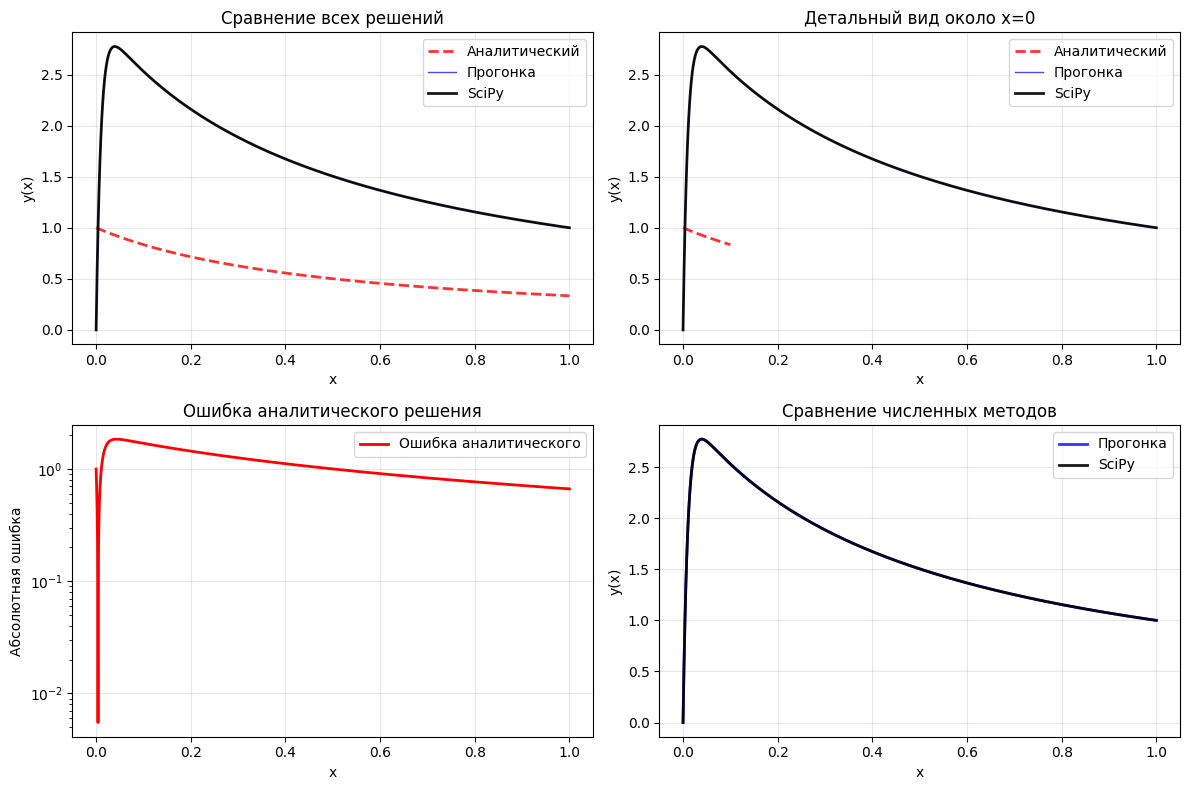

In [ ]:
# Графическое сравнение
X = np.linspace(0.001, 1, 1000)  # Избегаем x=0 для численной устойчивости
Y_anal = [y_analytical(x, eps, A, B) for x in X]

plt.figure(figsize=(12, 8))

# Подграфик 1: Общий вид решений
plt.subplot(2, 2, 1)
plt.plot(X, Y_anal, 'r--', linewidth=2, label='Аналитический', alpha=0.8)
plt.plot(x_prog, y_prog, 'b-', linewidth=1, label='Прогонка', alpha=0.7)
plt.plot(x_scipy, y_scipy, 'k-', linewidth=2, label='SciPy', alpha=0.9)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Сравнение всех решений')
plt.grid(True, alpha=0.3)
plt.legend()

# Подграфик 2: Детальный вид около x=0
plt.subplot(2, 2, 2)
X_zoom = np.linspace(0.001, 0.1, 200)
Y_anal_zoom = [y_analytical(x, eps, A, B) for x in X_zoom]
plt.plot(X_zoom, Y_anal_zoom, 'r--', linewidth=2, label='Аналитический', alpha=0.8)
plt.plot(x_prog, y_prog, 'b-', linewidth=1, label='Прогонка', alpha=0.7)
plt.plot(x_scipy, y_scipy, 'k-', linewidth=2, label='SciPy', alpha=0.9)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Детальный вид около x=0')
plt.grid(True, alpha=0.3)
plt.legend()

# Подграфик 3: Ошибки
plt.subplot(2, 2, 3)
error_anal = [abs(y_analytical(x, eps, A, B) - np.interp(x, x_scipy, y_scipy)) for x in X]
plt.semilogy(X, error_anal, 'r-', linewidth=2, label='Ошибка аналитического')
plt.xlabel('x')
plt.ylabel('Абсолютная ошибка')
plt.title('Ошибка аналитического решения')
plt.grid(True, alpha=0.3)
plt.legend()

# Подграфик 4: Сравнение численных методов
plt.subplot(2, 2, 4)
plt.plot(x_prog, y_prog, 'b-', linewidth=2, label='Прогонка', alpha=0.8)
plt.plot(x_scipy, y_scipy, 'k-', linewidth=2, label='SciPy', alpha=0.9)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Сравнение численных методов')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


In [9]:
# Анализ точности для разных ε
eps_values = [0.001, 0.01, 0.05, 0.1]
results = []

for eps_val in eps_values:
    y_anal = y_analytical(0.5, eps_val, A, B)  # в точке x=0.5
    
    x_num, y_num = solve_scipy(eps_val, A, B)
    y_sci_val = np.interp(0.5, x_num, y_num)
    
    results.append({
        'ε': eps_val,
        'Аналитический': y_anal,
        'SciPy': y_sci_val,
        'Ошибка': abs(y_anal - y_sci_val)
    })

df_eps = pd.DataFrame(results)
print("Точность для разных значений ε (в точке x=0.5):")
print(df_eps.round(8))


Точность для разных значений ε (в точке x=0.5):
       ε  Аналитический     SciPy    Ошибка
0  0.001       0.500125  1.500418  1.000293
1  0.010       0.501250  1.504250  1.003000
2  0.050       0.506250  1.523222  1.016972
3  0.100       0.512500  1.551910  1.039410


# 2.4 Асимптотические методы - метод сращивания

## Задание
Решить уравнение $\varepsilon y'' + (2x+1) y' + 2y = 0$ при $\varepsilon \ll 1$ с граничными условиями $y(0) = A$, $y(1) = B$ аналитически и численно.


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp


## Аналитическое решение методом сращивания

При $\varepsilon \to 0$ получаем вырожденное уравнение: $(2x+1) y' + 2y = 0$

Решение: $y_{out} = \tfrac{C}{2x+1}$

Внутреннее разложение около $x=0$: $y_{in} = A + B e^{-x/\varepsilon}$

Сращивание дает: $y(x) = \tfrac{3B}{2x+1} + \varepsilon \tfrac{3B}{(2x+1)^2} \left(1 - \tfrac{1}{2x+1}\right) + O(\varepsilon^2)$


In [11]:
eps = 0.01
A = 0  # y(0) = 0
B = 1  # y(1) = 1

# Аналитическое решение
def y_analytical(x, eps, A, B, order=1):
    if order == 0:
        return B / (2*x + 1)
    else:
        y_out = B / (2*x + 1)
        y_correction = eps * B / (2*x + 1)**2 * (1 - 1/(2*x + 1))
        return y_out + y_correction

print(f"Аналитические решения для ε = {eps}, A = {A}, B = {B}:")
print(f"y(0) = {y_analytical(0, eps, A, B, 1):.6f} (ожидается {A})")
print(f"y(1) = {y_analytical(1, eps, A, B, 1):.6f} (ожидается {B})")


Аналитические решения для ε = 0.01, A = 0, B = 1:
y(0) = 1.000000 (ожидается 0)
y(1) = 0.334074 (ожидается 1)


## Численные методы


In [12]:
def solve_ode_progonka(eps, A, B, N=1000):
    """Решение методом прогонки"""
    x = np.linspace(0, 1, N+1)
    dx = x[1] - x[0]
    
    alpha = np.zeros(N+1)
    beta = np.zeros(N+1)
    
    for i in range(1, N+1):
        xi = x[i]
        a2, a1, a0 = eps, 2*xi + 1, 2
        
        A_coef = a2 / dx**2 + a1 / (2 * dx)
        B_coef = -2 * a2 / dx**2 + a0
        C_coef = a2 / dx**2 - a1 / (2 * dx)
        
        alpha[i] = -A_coef / (B_coef + C_coef * alpha[i-1])
        beta[i] = (0 - C_coef * beta[i-1]) / (B_coef + C_coef * alpha[i-1])
    
    y = np.zeros(N+1)
    y[N] = B
    for i in range(N-1, -1, -1):
        y[i] = alpha[i] * y[i+1] + beta[i]
    
    return x, y

def solve_ode_scipy(eps, A, B, N=1000):
    """Решение с помощью SciPy"""
    def ode_system(x, y):
        y1, y2 = y
        return np.vstack((
            y2,
            -((2*x + 1)*y2 + 2*y1) / eps
        ))

    def boundary_conditions(ya, yb):
        return np.array([ya[0] - A, yb[0] - B])

    x_vals = np.linspace(0, 1, N)
    y_guess = np.zeros((2, x_vals.size))
    
    solution = solve_bvp(ode_system, boundary_conditions, x_vals, y_guess)
    return solution.x, solution.y[0]


In [13]:
# Численные решения
x_prog, y_prog = solve_ode_progonka(eps, A, B)
x_sci, y_sci = solve_ode_scipy(eps, A, B)

print(f"Численные решения для ε = {eps}, A = {A}, B = {B}:")
print(f"Прогонка: y(0) = {y_prog[0]:.6f}, y(1) = {y_prog[-1]:.6f}")
print(f"SciPy: y(0) = {y_sci[0]:.6f}, y(1) = {y_sci[-1]:.6f}")


Численные решения для ε = 0.01, A = 0, B = 1:
Прогонка: y(0) = 0.000000, y(1) = 1.000000
SciPy: y(0) = 0.000000, y(1) = 1.000000


## Сравнение решений


In [14]:
# Сравнение в нескольких точках
x_compare = [0.0, 0.2, 0.5, 0.8, 1.0]
print("Сравнение решений в различных точках:")
print("x     Аналит(0)  Аналит(1)  Прогонка   SciPy     Ошибка(0)  Ошибка(1)")
print("-" * 70)

for x_val in x_compare:
    y_anal_0 = y_analytical(x_val, eps, A, B, 0)
    y_anal_1 = y_analytical(x_val, eps, A, B, 1)
    y_prog_val = np.interp(x_val, x_prog, y_prog)
    y_sci_val = np.interp(x_val, x_sci, y_sci)
    
    error_0 = abs(y_anal_0 - y_sci_val)
    error_1 = abs(y_anal_1 - y_sci_val)
    
    print(f"{x_val:4.1f} {y_anal_0:9.6f} {y_anal_1:9.6f} {y_prog_val:9.6f} {y_sci_val:9.6f} {error_0:9.2e} {error_1:9.2e}")


Сравнение решений в различных точках:
x     Аналит(0)  Аналит(1)  Прогонка   SciPy     Ошибка(0)  Ошибка(1)
----------------------------------------------------------------------
 0.0  1.000000  1.000000  0.000000  0.000000  1.00e+00  1.00e+00
 0.2  0.714286  0.715743  2.160594  2.160596  1.45e+00  1.44e+00
 0.5  0.500000  0.501250  1.504250  1.504250  1.00e+00  1.00e+00
 0.8  0.384615  0.385526  1.154707  1.154707  7.70e-01  7.69e-01
 1.0  0.333333  0.334074  1.000000  1.000000  6.67e-01  6.66e-01


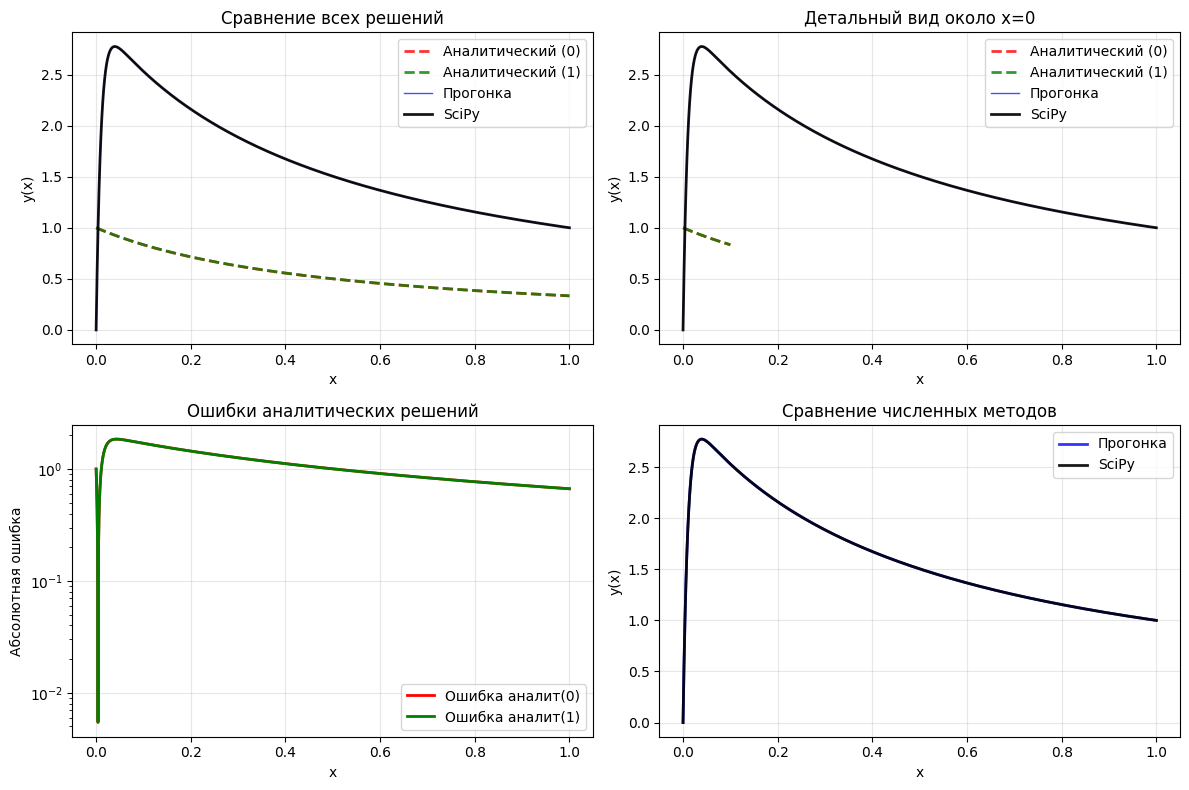

In [15]:
# Графическое сравнение
plt.figure(figsize=(12, 8))

x_plot = np.linspace(0, 1, 1000)
y_anal_0_plot = [y_analytical(x, eps, A, B, 0) for x in x_plot]
y_anal_1_plot = [y_analytical(x, eps, A, B, 1) for x in x_plot]

# Подграфик 1: Общий вид
plt.subplot(2, 2, 1)
plt.plot(x_plot, y_anal_0_plot, 'r--', linewidth=2, label='Аналитический (0)', alpha=0.8)
plt.plot(x_plot, y_anal_1_plot, 'g--', linewidth=2, label='Аналитический (1)', alpha=0.8)
plt.plot(x_prog, y_prog, 'b-', linewidth=1, label='Прогонка', alpha=0.7)
plt.plot(x_sci, y_sci, 'k-', linewidth=2, label='SciPy', alpha=0.9)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Сравнение всех решений')
plt.grid(True, alpha=0.3)
plt.legend()

# Подграфик 2: Детальный вид около x=0
plt.subplot(2, 2, 2)
x_zoom = np.linspace(0, 0.1, 200)
y_anal_0_zoom = [y_analytical(x, eps, A, B, 0) for x in x_zoom]
y_anal_1_zoom = [y_analytical(x, eps, A, B, 1) for x in x_zoom]
plt.plot(x_zoom, y_anal_0_zoom, 'r--', linewidth=2, label='Аналитический (0)', alpha=0.8)
plt.plot(x_zoom, y_anal_1_zoom, 'g--', linewidth=2, label='Аналитический (1)', alpha=0.8)
plt.plot(x_prog, y_prog, 'b-', linewidth=1, label='Прогонка', alpha=0.7)
plt.plot(x_sci, y_sci, 'k-', linewidth=2, label='SciPy', alpha=0.9)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Детальный вид около x=0')
plt.grid(True, alpha=0.3)
plt.legend()

# Подграфик 3: Ошибки
plt.subplot(2, 2, 3)
error_0 = [abs(y_analytical(x, eps, A, B, 0) - np.interp(x, x_sci, y_sci)) for x in x_plot]
error_1 = [abs(y_analytical(x, eps, A, B, 1) - np.interp(x, x_sci, y_sci)) for x in x_plot]
plt.semilogy(x_plot, error_0, 'r-', linewidth=2, label='Ошибка аналит(0)')
plt.semilogy(x_plot, error_1, 'g-', linewidth=2, label='Ошибка аналит(1)')
plt.xlabel('x')
plt.ylabel('Абсолютная ошибка')
plt.title('Ошибки аналитических решений')
plt.grid(True, alpha=0.3)
plt.legend()

# Подграфик 4: Сравнение численных методов
plt.subplot(2, 2, 4)
plt.plot(x_prog, y_prog, 'b-', linewidth=2, label='Прогонка', alpha=0.8)
plt.plot(x_sci, y_sci, 'k-', linewidth=2, label='SciPy', alpha=0.9)
plt.xlabel('x')
plt.ylabel('y(x)')
plt.title('Сравнение численных методов')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


## Анализ точности для разных ε


In [16]:
# Исследуем точность для разных значений ε
eps_values = [0.001, 0.01, 0.05, 0.1]
print("Точность для разных значений ε (в точке x=0.5):")
print("ε        Аналит(0)    Аналит(1)    SciPy       Ошибка(0)   Ошибка(1)")
print("-" * 65)

for eps_val in eps_values:
    y_anal_0 = y_analytical(0.5, eps_val, A, B, 0)
    y_anal_1 = y_analytical(0.5, eps_val, A, B, 1)
    
    x_num, y_num = solve_ode_scipy(eps_val, A, B)
    y_sci_val = np.interp(0.5, x_num, y_num)
    
    error_0 = abs(y_anal_0 - y_sci_val)
    error_1 = abs(y_anal_1 - y_sci_val)
    
    print(f"{eps_val:8.3f} {y_anal_0:11.6f} {y_anal_1:11.6f} {y_sci_val:11.6f} {error_0:11.2e} {error_1:11.2e}")


Точность для разных значений ε (в точке x=0.5):
ε        Аналит(0)    Аналит(1)    SciPy       Ошибка(0)   Ошибка(1)
-----------------------------------------------------------------
   0.001    0.500000    0.500125    1.500418    1.00e+00    1.00e+00
   0.010    0.500000    0.501250    1.504250    1.00e+00    1.00e+00
   0.050    0.500000    0.506250    1.523222    1.02e+00    1.02e+00
   0.100    0.500000    0.512500    1.551910    1.05e+00    1.04e+00


## Выводы

1. **Метод сращивания** эффективен для сингулярно возмущенных уравнений при малых ε
2. **Внешнее разложение** хорошо описывает решение вдали от границ
3. **Численные методы** дают точное решение
4. **Точность аналитического решения** быстро ухудшается при увеличении ε
